# **Linear Support Vector Machines (from Scratch)**

This tutorial will guide you through the implementation of linear support vector machines in Python. While scikit-learn is a useful tool for utilizing support vector machines, it is largely a black box that does not help you gain a deeper understanding of the concepts covered in the lecture.

Therefore, we will be using only numpy and a well-known convex optimization library called [CVXOPT](https://cvxopt.org/) in the first part of this tutorial. By building the SVM from scratch, you will have a better understanding of the mathematical concepts behind SVMs and how they are optimized.


Let's first import some libraries:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
from sklearn.datasets import load_iris # Only used to load the dataset
from matplotlib.colors import ListedColormap


# **Dataset**
We will be using the well-known [IRIS dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) for this tutorial. The dataset includes 50 samples from each of three species of Iris (Iris setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample, including the length and width of the sepals and petals in centimeters.

For the purpose of binary classification, we will only be retaining two classes.
Moreover, to make the input space easier to plot, we will only consider two features (i.e., petal length and width).

Let's load and plot the data:

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])
iris_df.head()

# Retain only 2 linearly separable classes
# One class will have "-1" as target, the other "+1" (as required by SVMs)
iris_df = iris_df[iris_df["target"].isin([0,1])]
iris_df["target"] = iris_df[["target"]].replace(0,-1)

# Select only 2 attributes
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
iris_df.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,-1.0
1,1.4,0.2,-1.0
2,1.3,0.2,-1.0
3,1.5,0.2,-1.0
4,1.4,0.2,-1.0


We now convert the data into numpy variables:

In [3]:
X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy()

We also define a function that we will use to plot data:

In [4]:
def plot_data(X, y, model=None, plot_boundaries=False, plot_svect=False):

    # hyperparameter for boardry
    x_min = X[:,0].min()-0.5
    x_max = X[:,0].max()+0.5
    y_min = X[:,1].min()-0.5
    y_max = X[:,1].max()+0.5
    step = 0.05

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                        np.arange(y_min, y_max, step)
                        )
    if plot_boundaries:
      z = model.predict(np.c_[xx.ravel(), yy.ravel()])
      z = z.reshape(xx.shape)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#003300'])

    plt.figure(figsize=(8, 5), dpi=96)

    if plot_boundaries:
      plt.pcolormesh(xx, yy, z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    if plot_svect:
      X_sv = X[model.sp_v_i]
      plt.scatter(X_sv[:, 0], X_sv[:, 1], s=200,
                c="None", edgecolors=["blue"], marker="o", label="support vector")

    plt.show()

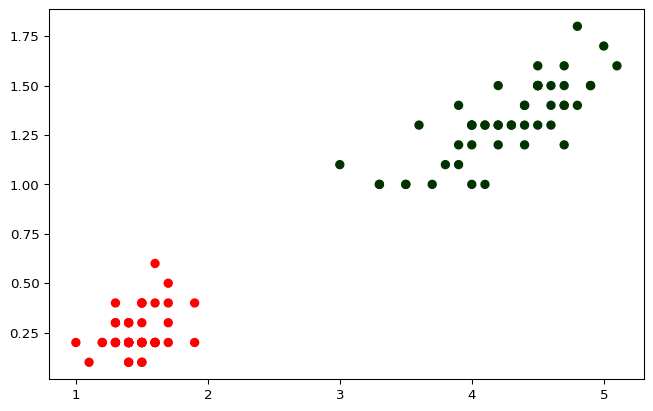

In [5]:
plot_data(X, y)

Hard margin doesnt have room for error (linearly separable) compared to soft margin

## **Linear Hard-Margin SVM**

The problem that we have to solve in a linear hard-margin SVM is the following:

$
\begin{equation*}
\begin{aligned}
& \mathbf{w}^*, b^* = \underset{\mathbf{w},b}{\operatorname{argmin}} \frac{1}{2} \mathbf{w}^T   \mathbf{w}\\
& \text{s.t.} \:
t_i (\mathbf{w}^T \mathbf{x}_i+ b) \geq 1 \; \textrm{for}\; i=1,..,N
\end{aligned}
\end{equation*}
$

Where:
$\mathbf{w}$ is the vector containing the learnable weights, $b$ is the bias term, and $t_i$ is the label for the i-th sample in the training dataset.

The first thing we need to do is to feed this problem into our convex optimization. CVXOPT solves problems framed in this way:

$
\begin{equation*}
\begin{aligned}
& \mathbf{z}^* = \underset{\mathbf{z}}{\operatorname{argmin}} \frac{1}{2} \mathbf{z}^T \mathbf{P} \mathbf{z} + \mathbf{q}^T \mathbf{z} \\
& \text{s.t.} \:
\mathbf{G}\mathbf{z} \leq \mathbf{h} \\
& \text{s.t.} \: \mathbf{A}\mathbf{z} = \mathbf{b}
\end{aligned}
\end{equation*}
$



We have to manipulate our problem such that we can fit it into the one that CVXOPT can solve. We need to find proper values for $\mathbf{A}$, $\mathbf{b}$, $\mathbf{P}$, $\mathbf{q}$, $\mathbf{G}$, $\mathbf{h}$ for the hard-margin linear SVM problem.

## Setting $\mathbf{A}$ and $\mathbf{b}$
In our problem, we do not have any equality constraint. We can set $\mathbf{A}$ and $b$ to zeros or simply do not specify them when calling the CVXOPT optimizer.

## Setting $\mathbf{P}$ and $\mathbf{q}$
We can notice that CVXOPT optimizes a single vector $\mathbf{z}$ (here we called it $\mathbf{z}$ to avoid confusion with the input features of the model, but CVXOPTi calls it $\mathbf{x}$,  as you can see in the optimization code).

In our case, we have two optimization variables: the weight vector $\mathbf{w}=[w_1, w_2, ..., w_D]^T$ (where D is the number of input features) and the bias term (scalar) $b$. During the lecture, we separated them for mathematical convenience, but here we need to merge them again to fit what CVXOPT expects.  

To do it, we can embed all the parameters into a single parameter vector $\mathbf{w}=[b, w_1, w_2, ..., w_D]^T$ and concatenate a "1" into the input $\mathbf{x}_i = [1, x_1, x_2, ..., x_D]^T$.

With this trick, we can summarize all the parameters into a single vector ($\mathbf{z}=\mathbf{w}$) as required by CVXOPT.

If we do that, however, we have to slightly modify our problem as follows:

$
\begin{equation*}
\begin{aligned}
& \mathbf{w}^* = \underset{\mathbf{w}}{\operatorname{argmin}} \frac{1}{2} \mathbf{w}^T  \mathbf{P}\mathbf{w}\\
& \text{s.t.} \:
t_i (\mathbf{w}^T \mathbf{x}_i) \geq 1 \; \textrm{for}\; i=1,..,N
\end{aligned}
\end{equation*}
$

Where

$
\mathbf{P}=\begin{bmatrix} 0 & 0 & 0 & 0 & ... & 0 \\
0 & 1 & 0 & 0 & ... & 0 \\
0 & 0 & 1 & 0 & ... & 0 \\
0 & 0 & 0 & 1 & ... & 0 \\
0 & 0 & 0 & 0 & ... & 1 \\
\end{bmatrix}$

$\mathbf{P}$ is a squared matrix of dimenionsality  $(D+1) \times (D+1)$. It is an identity matrix except for the first element P[0,0] that should be set to zero to avoid accounting for the bias term when computing $||\mathbf{w}||^2 = \mathbf{w}^T \mathbf{w} $.  

For our problem, we do not need the part corresponding to the vector $\mathbf{q}$. We can thus set $\mathbf{q}=[0, 0, 0, ..., 0]^T$ as a vector composed of D+1 zeros.

## Setting $\mathbf{G}$ and $\mathbf{h}$

Let's now move to the inequality constraints. We have the following:

$t_i (\mathbf{w}^T \mathbf{x}_i) \geq 1 \; \textrm{for}\; i=1,..,N$

where $\mathbf{w}=[b, w_1, w_2, ..., w_D]^T$ and $\mathbf{x}_i=[1, x_1, x_2, ..., x_D]^T$

We have to process it to make it match with what CVXOPT expects:

$\mathbf{G}\mathbf{z} \leq \mathbf{h} $


First, we need to turn the "$\geq$" into "$\leq$". We can simply multiply both sides of the inequality by "-1":

$-t_i (\mathbf{w}^T \mathbf{x}_i) \leq -1 \; \textrm{for}\; i=1,..,N$

We can now further manipulate using the property of the dot product and get the following expression:

$(-t_i\mathbf{x}_i^T) (\mathbf{w}) \leq -1 \; \textrm{for}\; i=1,..,N$

For each input $\mathbf{x}_i$, we need to do the following computations:

$[-t_i -t_i x_{i,1} -t_i x_{i,2} - ... - t_i x_{i,D}] \begin{bmatrix} b\\w_1\\w_2\\...\\w_D \end{bmatrix} = -t_ib -t_ix_{i,1}w_1 -t_ix_{i,2}w_2 - .... -t_ix_{i,D}w_D \leq -1$




If we vectorize the inequality (i.e, considering all the inputs N), we can write it as:

$\mathbf{G}\mathbf{w} \leq \mathbf{h} $

where:

$
\mathbf{G}=\begin{bmatrix} -t_1 & -t_1 x_{1,1} & -t_1 x_{1,2} & -t_1 x_{1,3} & ... & -t_1 x_{1,D} \\
-t_2 & -t_2 x_{2,1} & -t_2 x_{2,2} & -t_2 x_{2,3} & ... & -t_2 x_{2,D} \\
-t_3 & -t_3 x_{3,1} & -t_3 x_{3,2} & -t_3 x_{3,3} & ... & -t_3 x_{3,D} \\
... & ... & ... & ... & ... & ... \\
-t_N & -t_N x_{N,1} & -t_N x_{N,2} & -t_N x_{N,3} & ... & -t_N x_{N,D} \\
\end{bmatrix}$

is a matrix of dimensionality $N \times (D+1) $

$\mathbf{w}=[b, w_1, w_2, ..., w_D]^T$ is a vector of dimensionality $(D+1)$

$\mathbf{h}=[-1,-1,-1,...,-1]^T$ is a vector of dimensionality $(N)$

As you can see the dimensionalities all matches. You can easily verify that with these matrixes we perform all the needed computations for all the N input examples.

Now, we can define the SVM model and plug these matrices into the optimization library:




In [ ]:
class SVM():
    def __init__(self):
        self.has_fitted = False
        # threshold for identifying that this vector is support vector
        self.sp_v_threshold = 1e-8
        # list for supoort vector indexes
        self.sp_v_i = []

    def fit(self, X, y):
        # specify the shape
        n = len(X)
        dim = len(X[0])

        # initialize variables (see computations above)
        self.P = matrix(np.identity(dim + 1, dtype=float))
        self.q = matrix(np.zeros((dim + 1,), dtype=float))
        self.G = matrix(np.zeros((n, dim + 1), dtype=float))
        self.h = -matrix(np.ones((n,), dtype=float))
        self.P[0, 0] = 0

        # Filling the G Matrix
        # G = [y_1, --y_1 x_1^T--; y_2, --y_2 x_2^T--, ..., y_n, --y_n x_n^T]
        for i in range(n):
            self.G[i, 0] = -y[i]
            self.G[i, 1:] = -X[i, :] * y[i]

        # Solve the problem
        sol = solvers.qp(self.P,
                         self.q,
                         self.G,
                         self.h
                         )

        # Unpack the solution
        self.w = np.zeros(dim,) # weight
        self.b = sol["x"][0] # bias
        for i in range(1, dim + 1):
            self.w[i - 1] = sol["x"][i]

        # find the indexes of support vectors
        for i in range(n):
            v = y[i] * (np.dot(self.w, X[i]) + self.b)
            if v < (1 + self.sp_v_threshold):
                self.sp_v_i.append(i)
        self.has_fitted = True
        return self.w, self.b

    def predict(self, X):
        return np.sign(np.dot(self.w, X.T) + self.b)

Now, we can train the SVM and plot the decision boundaries:

     pcost       dcost       gap    pres   dres
 0:  2.0420e-01  1.4894e+01  3e+02  2e+00  2e+02
 1:  1.7498e+00 -2.7759e+01  4e+01  3e-01  3e+01
 2:  1.8727e+00 -2.5337e+00  5e+00  2e-02  3e+00
 3:  1.1942e+00  5.7960e-01  6e-01  8e-04  9e-02
 4:  1.2979e+00  7.9137e-01  5e-01  4e-04  5e-02
 5:  1.1784e+00  1.1578e+00  2e-02  1e-05  1e-03
 6:  1.1765e+00  1.1763e+00  2e-04  1e-07  1e-05
 7:  1.1765e+00  1.1765e+00  2e-06  1e-09  1e-07
 8:  1.1765e+00  1.1765e+00  2e-08  1e-11  1e-09
Optimal solution found.


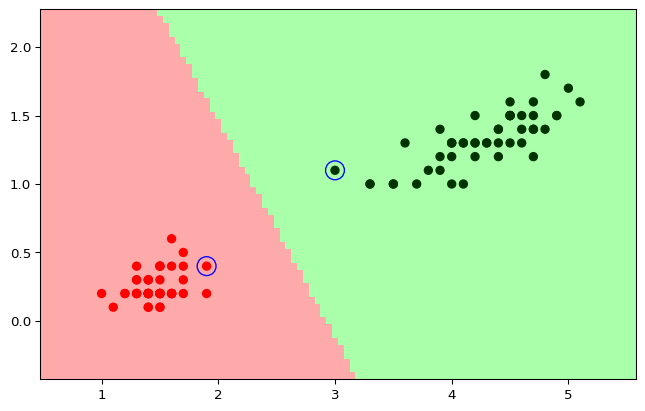

In [ ]:
svm = SVM()
w, b =svm.fit(X, y)
plot_data(X, y, model=svm, plot_boundaries=True, plot_svect=True)

By solving the convex optimization problem, we can identify a line (or a hyperplane for higher dimensional data) that effectively separates the two classes. In the figure, you can see the support vectors highlighted in blue. In a hard-margin SVM, the support vectors are the data points that are closest to the separation plane.

Great, this seems to work as expected!

It's worth noting that support vector machines are not the only technique that can be used to solve this problem. In a previous lecture, we learned that logistic regression can also be used for binary classification on linearly separable classes.

Let's now utilize (for simplicity) scikit-learn and compare the solutions learned by both SVMs and logistic regression:

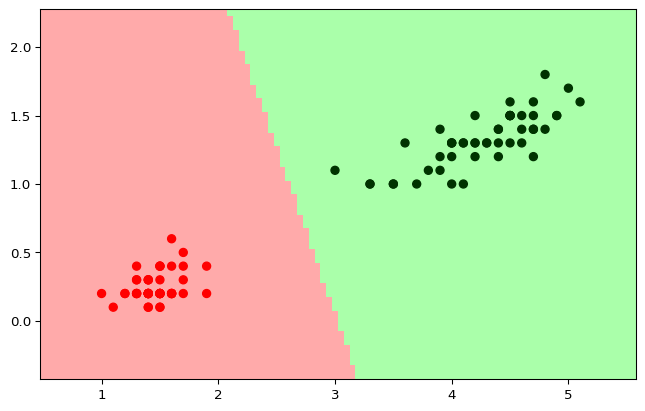

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X, y.ravel())
w = np.array([clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]])
plot_data(X, y, model=clf, plot_boundaries=True, plot_svect=False)

Logistic regression provides another effective solution for this problem. Although the solutions may appear similar at first glance, there are actually differences (see the slope of the line). On the other hand, a linear support vector machine (SVM) optimizes an objective function that differs from the binary cross-entropy function used in logistic regression.


## **Linear Soft-Margin SVM**

Let's now move on to a slightly more complex classification task. Specifically, we will consider two classes from the IRIS dataset that are not perfectly linearly separable:


In [ ]:
iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])
iris_df.head()

# Retain only 2 linearly separable classes
# One class will have "-1" as target, the other "+1" (as required by SVMs)
iris_df = iris_df[iris_df["target"].isin([1,2])]
iris_df["target"] = iris_df[["target"]].replace(2,-1)

# Select only 2 attributes
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
iris_df.head()

,petal length (cm),petal width (cm),target
50,4.7,1.4,1.0
51,4.5,1.5,1.0
52,4.9,1.5,1.0
53,4.0,1.3,1.0
54,4.6,1.5,1.0


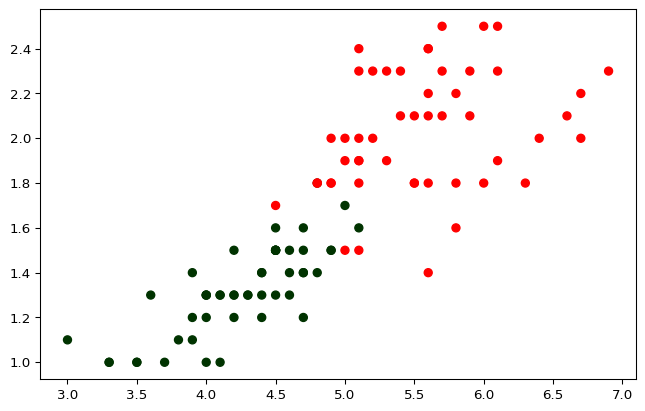

In [ ]:
X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy()
plot_data(X, y)

side notes:
high correlation between the data (running and jogging example)

Let's try to use the linear hard-margin SVM implemented in the previous section:

In [ ]:
svm = SVM()
w, b =svm.fit(X, y)

     pcost       dcost       gap    pres   dres
 0:  2.0420e-01  1.4894e+01  3e+02  2e+00  2e+02
 1:  1.7498e+00 -2.7759e+01  4e+01  3e-01  3e+01
 2:  1.8727e+00 -2.5337e+00  5e+00  2e-02  3e+00
 3:  1.1942e+00  5.7960e-01  6e-01  8e-04  9e-02
 4:  1.2979e+00  7.9137e-01  5e-01  4e-04  5e-02
 5:  1.1784e+00  1.1578e+00  2e-02  1e-05  1e-03
 6:  1.1765e+00  1.1763e+00  2e-04  1e-07  1e-05
 7:  1.1765e+00  1.1765e+00  2e-06  1e-09  1e-07
 8:  1.1765e+00  1.1765e+00  2e-08  1e-11  1e-09
Optimal solution found.


As you can see, the optimizer raises an error.

*Could you guess why?*

The optimization problem has no solutions because a line separating the two classes perfectly does not exist.

The solution is using linear **soft-margin** SVMs which are tolerant against classification errors. Soft-margin SVMs introduce the hyperparameter C to control the amount of penalization assigned to errors. In particular:
- Large values of C allows for little tolerance against classification errors
- Small values of C allows for larger tolerance against classification errors

For simplicity, let's implement linear soft-margin SVMs with scikit-learn and see what happens with different values of C:

MCQ: above (like the C thing above)

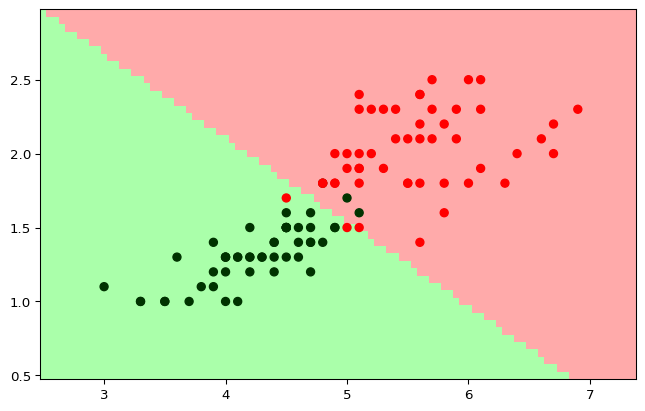

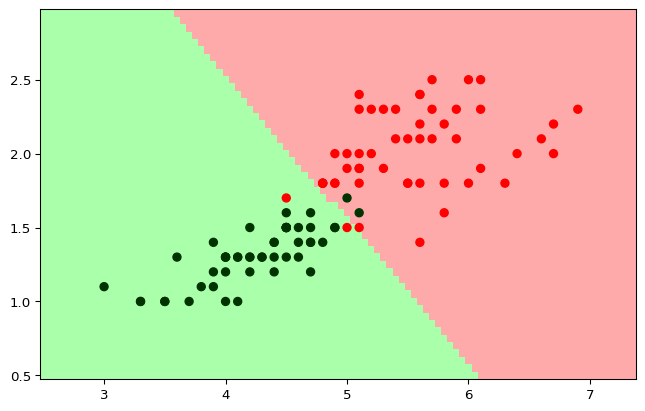

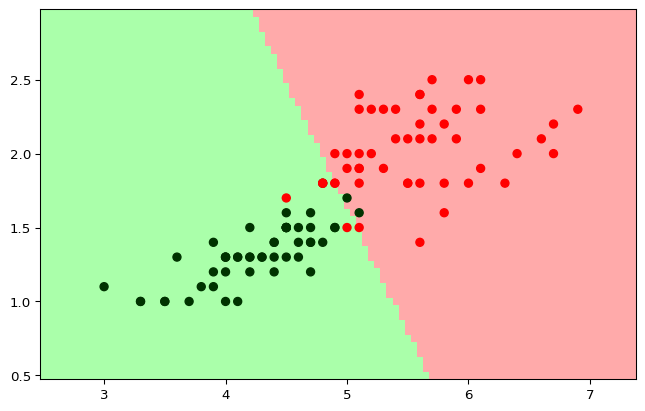

In [ ]:
from sklearn import svm
for c in [10.0, 1.0, 0.01]:
  clf = svm.SVC(kernel="linear", C=c)
  clf.fit(X, y.ravel())
  plot_data(X, y, model=clf, plot_boundaries=True, plot_svect=False)

As you can see, depending on the value of C we end up with different solutions.
More specifically, you can see that when using $C=10$ we only have 4 errors (we misclassify 2 red points and two black ones). When using $C=0.01$, we tolerate 7 errors (4 red and 2 black).

It looks like $C=1.0$ is a good compromize:

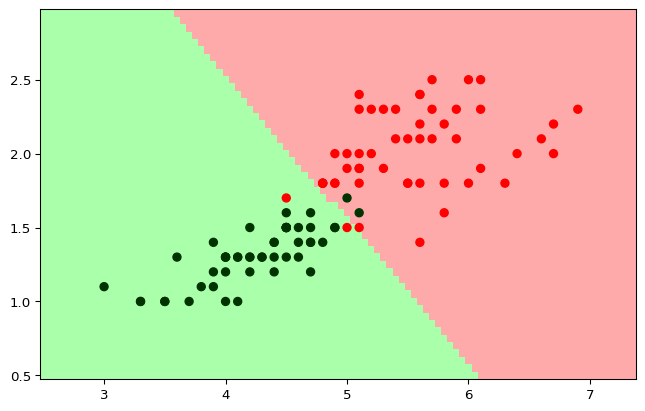

In [ ]:
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y.ravel())
plot_data(X, y, model=clf, plot_boundaries=True, plot_svect=False)

Also in this case, we can compare the solution provided by a soft-margin SVM with that provided by logistic regression.


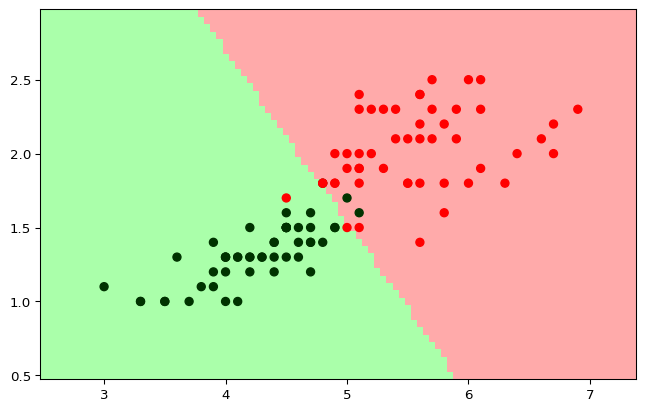

In [ ]:
clf = LogisticRegression(random_state=0).fit(X, y.ravel())
plot_data(X, y, model=clf, plot_boundaries=True, plot_svect=False)

Similar to what was observed before, also logistic regression discovers a good solution for this problem. The solutions learned by SVMs and logistic regressions are different because the objectives are different (binary cross-entropy for logistic regression and hinge loss for soft-margin SVMs).


As mentioned in the main lecture, it is possible to optimize a linear soft-margin SVM with gradient descent (as opposed to solving the context optimization problem as done before). All we have to do to, is use the hinge loss are the training objective:

$L= C \sum_{i=1}^N \max(0,1-t_i(\mathbf{w}^T \mathbf{x} +b)) + \frac{1}{2} ||\mathbf{w}||^2$


The code below uses Torch to implement a linear soft-margin SVM.

Side notes: loss for SVM: hinge loss

In [ ]:
import torch
import torch.nn as nn

class LinearSVM(nn.Module):
    """
    Defines a linear SVM model to be trained by gradient descent (Adam optimizer) in PyTorch.
    """
    def __init__(self, C=1.0, lr=1e-2, epochs=10):
        """
        Args:
            C (float): C parameter of a linear SVM.
            lr (float): Learning rate for the Adam optimizer.
            nr_epochs (int): Number of epochs to train the SVM for.
        """
        super().__init__()

        # Initialize hyperparameters
        self.C = C
        self.lr = lr
        self.epochs = epochs
        self.model = nn.Linear(2, 1)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def _hinge_loss(self, y_pred, t):
        """
        Computes SVM's hinge loss
        Args:
            y_pred: output of the linear model
            t: Ground truth vector.
        Returns:
            Loss function value (a scalar).
        """
        #print(torch.norm(self.w**2)/2)
        #print(self.C * torch.sum(nn.functional.relu(1 - t*y_pred)))
        weight = self.model.weight.squeeze()
        loss = self.C * torch.sum(torch.clamp(1 - t * y_pred, min=0))
        loss += (weight.t() @ weight) / 2.0
        return loss




    def fit(self, X, t):
        """
        Fits a linear SVM model to data X with labels y.
        Args:
            X (numpy.ndarray): Data X
            t (numpy.ndarray): Ground truth vector.
        """


        # Train linear SVM by gradient descent (Adam) for self.nr_epochs epochs
        for epoch in range(1, self.epochs+1):

            # Compute decision function values for the training set
            y_pred = self.model.forward(X)

            # Compute loss per sample
            loss = self._hinge_loss(y_pred, t)

            #loss = loss/X.shape[0]

            # Compute gradients and update parameters by backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()



    def predict(self, X):
        """
        Runs prediction step on input data X.
        Args:
            X (numpy.ndarray): Data X with predictor variables.
        Returns:
            numpy.ndarray: Binary prediction for each input sample (1 or -1).
        """
        X = torch.Tensor(X)
        return torch.sign(self.model.forward(X)).detach().numpy()

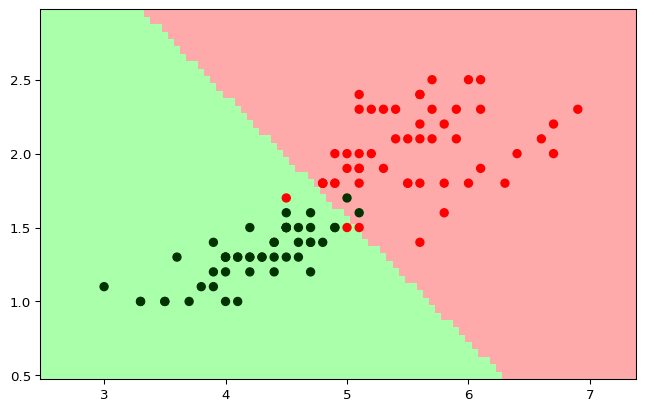

In [ ]:
linear_svm_gd = LinearSVM(lr=0.1, epochs=1000, C=1.0)
linear_svm_gd.fit(torch.Tensor(X),torch.Tensor(y))
plot_data(X, y, model=linear_svm_gd, plot_boundaries=True, plot_svect=False)

As you may have noticed, gradient descent can converge to a satisfactory solution. However, this approach requires careful setting of additional hyperparameters, which can be a bit cumbersome. Specifically, we need to select the appropriate learning rate and number of epochs to obtain meaningful outcomes. Therefore, in this particular case, it is preferable to use the previous method, which involves solving the convex optimization problem. This method eliminates the need for selecting additional hyperparameters (we only have to select C) and is therefore a more efficient solution.
